# Imports  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import  Bar, Layout, Figure
from plotly import __version__
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Iterable, Set
import sys
from IPython.core.display import display, HTML

import Orange
import matplotlib.pyplot as plt

display(HTML("<style>.container { width:100% !important; }</style>"))


%matplotlib inline

sys.path.append('/home/laugustyniak/github/phd/sentiment-backend/')

from aspects.analysis import statistics_dataset
from aspects.analysis import nlp_architect

init_notebook_mode(connected=True)

In [7]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
scmamp = importr('scmamp')

ModuleNotFoundError: No module named 'rpy2'

In [3]:
results_path = Path('/home/laugustyniak/luk.augustyniak@gmail.com/Projects/PRELUDIUM/Artykuły/aspect-based sentiment 2018/journal')

In [4]:
# dataset_sub_name = 'restaurants'
dataset_sub_name = 'laptops'

In [5]:
# EMBEDDINGS_SUBSET = ['fastText-crawl', 'Amazon Reviews', 'numberbatch', 'Glove 840B', 'word2vec']

In [6]:
embedding_names = {
    'wiki-news-300d-1M': 'fastText-wiki', 
    'glove.42B.300d': 'Glove 42B', 
    'crawl-300d-2M': 'fastText-crawl', 
    'sentic2vec': 'Amazon Reviews',
    'glove.6B.100d': 'Glove.6B.100', 
    'numberbatch-en': 'numberbatch', 
    'glove.6B.50d': 'Glove.6B.50', 
    'glove.840B.300d': 'Glove.840B',
    'glove.6B.200d': 'Glove.6B.200', 
    'glove.6B.300d': 'Glove.6B.300', 
    'GoogleNews-vectors-negative300': 'word2vec'
}

method_names = {
    'word lstm': 'Wo-LSTM',
    'word lstm crf': 'Wo-LSTM-CRF',
    'char word lstm': 'WoCh-LSTM',
    'char word lstm crf': 'WoCh-LSTM-CRF',
    'word bilstm': 'Wo-BiLSTM',
    'word bilstm crf': 'Wo-BiLSTM-CRF',
    'char word bilstm': 'WoCh-BiLSTM',
    'char word bilstm crf': 'WoCh-BiLSTM-CRF',
}

In [7]:
nlp_architect.get_models_metric(
        Path(
            f'../../../nlp-architect/examples/aspect_extraction/models-oxygen-14-all/models/'
        ), dataset_sub_name, embedding_names, 'f1')

,Glove 42B,fastText-crawl
Wo-LSTM,69.83,68.32
WoCh-LSTM,68.20,66.78
Wo-LSTM-CRF,NaN,NaN
WoCh-LSTM-CRF,NaN,76.35
Wo-BiLSTM,73.10,73.38
WoCh-BiLSTM,70.73,72.15
Wo-BiLSTM-CRF,79.47,77.62
WoCh-BiLSTM-CRF,80.16,77.63


# Get all results in one Data Frame

In [8]:
nlp_architect.get_models_metric(
        Path(
            f'../../../nlp-architect/examples/aspect_extraction/models-oxygen-1/models'
        ), dataset_sub_name, embedding_names)

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove.6B.100,numberbatch,Glove.6B.50,Glove.840B,Glove.6B.200,Glove.6B.300,word2vec
Wo-LSTM,64.70,70.68,70.68,55.74,62.29,55.87,29.27,68.99,65.14,66.77,59.42
WoCh-LSTM,55.35,68.24,70.41,60.38,63.50,61.63,53.80,69.77,67.04,65.93,66.20
Wo-LSTM-CRF,75.72,75.67,79.54,64.16,74.98,68.44,59.23,75.33,75.69,70.46,73.21
WoCh-LSTM-CRF,74.05,78.61,77.85,68.22,70.26,73.40,65.34,76.41,72.51,74.75,73.08
Wo-BiLSTM,69.21,74.63,73.27,61.05,67.42,62.55,53.41,74.43,72.70,72.97,68.38
WoCh-BiLSTM,65.58,74.22,75.50,65.59,67.24,64.54,62.06,75.23,71.14,69.12,71.19
Wo-BiLSTM-CRF,71.88,80.63,77.54,63.08,77.30,72.57,65.44,77.82,74.79,75.16,74.09
WoCh-BiLSTM-CRF,77.26,77.70,77.46,66.95,75.92,73.12,70.13,79.38,79.05,76.17,75.93


In [9]:
results_df = nlp_architect.merge_embeddings_and_architectures_results([
    nlp_architect.get_models_metric(
        Path(
            f'../../../nlp-architect/examples/aspect_extraction/models-oxygen-{str(i)}/models'
        ), dataset_sub_name, embedding_names) for i in range(1, 6)
])

In [10]:
results_df

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove.6B.100,numberbatch,Glove.6B.50,Glove.840B,Glove.6B.200,Glove.6B.300,word2vec
Wo-BiLSTM,"[69.21, 59.0, 61.47, 65.1, 57.9]","[74.63, 74.92, 75.3, 72.3, 71.76]","[73.27, 73.68, 71.49, 73.03, 70.13]","[61.05, 61.33, 59.88, 60.67, 58.17]","[67.42, 68.03, 61.21, 67.2, 60.86]","[62.55, 66.44, 59.8, 55.89, 45.41]","[53.41, 51.5, 53.28, 54.2, 51.15]","[74.43, 73.59, 73.72, 72.19, 72.3]","[72.7, 71.19, 65.26, 66.32, 68.08]","[72.97, 71.8, 72.05, 69.2, 69.99]","[68.38, 69.21, 68.18, 63.39, 65.64]"
Wo-BiLSTM-CRF,"[71.88, 76.65, 77.86, 76.17, 77.69]","[80.63, 79.87, 81.1, 79.64, 79.18]","[77.54, 76.71, 79.26, 80.16, 78.02]","[63.08, 65.13, 63.95, 64.16, 63.15]","[77.3, 77.83, 77.48, 69.06, 75.55]","[72.57, 71.04, 72.22, 73.55, 70.79]","[65.44, 56.43, 65.44, 65.36, 64.27]","[77.82, 78.77, 78.91, 79.97, 79.48]","[74.79, 79.54, 76.0, 77.49, 78.3]","[75.16, 77.67, 76.68, 76.29, 75.59]","[74.09, 74.94, 73.41, 74.94, 72.29]"
Wo-LSTM,"[64.7, 63.22, 51.99, 59.69, 57.01]","[70.68, 66.94, 70.94, 68.23, 65.43]","[70.68, 70.09, 67.0, 59.3, 66.67]","[55.74, 51.79, 55.75, 52.27, 55.35]","[62.29, 56.48, 60.75, 53.38, 52.12]","[55.87, 60.52, 52.95, 57.87, 57.17]","[29.27, 47.12, 43.18, 42.54, 41.73]","[68.99, 70.91, 70.81, 64.0, 62.19]","[65.14, 59.82, 60.63, 64.79, 63.07]","[66.77, 66.89, 66.5, 61.69, 62.26]","[59.42, 61.98, 64.03, 56.79, 60.71]"
Wo-LSTM-CRF,"[75.72, 74.15, 71.62, 74.5, 72.33]","[75.67, 76.01, 76.02, 76.91, 77.34]","[79.54, 76.32, 75.95, 78.42, 74.54]","[64.16, 65.3, 64.55, 63.35, 63.4]","[74.98, 70.05, 74.49, 70.45, 71.33]","[68.44, 63.4, 68.86, 70.46, 69.78]","[59.23, 58.11, 56.57, 55.86, 57.62]","[75.33, 74.74, 77.33, 78.25, 77.96]","[75.69, 76.66, 76.68, 76.52, 74.17]","[70.46, 76.25, 73.54, 74.82, 72.48]","[73.21, 71.82, 70.23, 71.15, 72.98]"
WoCh-BiLSTM,"[65.58, 59.82, 67.06, 65.67, 55.19]","[74.22, 71.78, 74.45, 71.63, 73.48]","[75.5, 73.7, 72.52, 67.26, 73.21]","[65.59, 66.28, 64.99, 62.99, 65.45]","[67.24, 68.86, 67.07, 66.11, 67.01]","[64.54, 68.63, 62.47, 66.12, 66.67]","[62.06, 59.05, 59.2, 51.53, 64.1]","[75.23, 73.72, 73.98, 68.82, 70.14]","[71.14, 64.34, 69.78, 67.33, 67.3]","[69.12, 71.19, 71.29, 69.86, 70.15]","[71.19, 71.54, 69.04, 68.47, 63.6]"
WoCh-BiLSTM-CRF,"[77.26, 71.24, 77.71, 76.32, 77.67]","[77.7, 78.92, 77.81, 78.52, 78.08]","[77.46, 78.47, 78.19, 78.17, 81.36]","[66.95, 69.2, 69.52, 69.37, 68.21]","[75.92, 75.38, 76.95, 70.58, 75.57]","[73.12, 76.17, 76.25, 72.57, 72.33]","[70.13, 68.83, 72.44, 71.45, 72.38]","[79.38, 78.85, 79.45, 79.38, 78.6]","[79.05, 75.39, 75.55, 75.89, 77.96]","[76.17, 76.32, 76.19, 76.82, 76.52]","[75.93, 74.44, 76.3, 77.02, 73.21]"
WoCh-LSTM,"[55.35, 62.18, 56.48, 56.79, 59.02]","[68.24, 65.05, 68.97, 65.79, 69.31]","[70.41, 69.85, 68.15, 62.34, 57.8]","[60.38, 58.9, 57.41, 58.06, 60.28]","[63.5, 57.61, 61.26, 59.86, 60.95]","[61.63, 61.83, 58.41, 55.18, 51.78]","[53.8, 31.91, 54.97, 45.53, 51.3]","[69.77, 68.46, 69.29, 68.28, 69.66]","[67.04, 63.22, 61.93, 61.0, 63.75]","[65.93, 65.67, 65.5, 61.32, 64.52]","[66.2, 64.59, 63.45, 58.22, 63.03]"
WoCh-LSTM-CRF,"[74.05, 75.95, 73.9, 75.51, 75.23]","[78.61, 76.02, 77.54, 75.99, 78.63]","[77.85, 75.87, 75.86, 77.45, 75.63]","[68.22, 70.52, 66.95, 69.46, 70.04]","[70.26, 70.36, 74.41, 72.09, 72.74]","[73.4, 72.48, 73.66, 73.1, 73.09]","[65.34, 60.47, 61.89, 66.55, 66.37]","[76.41, 76.21, 77.12, 77.3, 76.24]","[72.51, 75.06, 73.98, 73.37, 75.06]","[74.75, 73.22, 74.5, 74.39, 73.9]","[73.08, 74.23, 75.55, 76.81, 72.55]"


In [11]:
results_df_precision = nlp_architect.merge_embeddings_and_architectures_results([
    nlp_architect.get_models_metric(
        Path(
            f'../../../nlp-architect/examples/aspect_extraction/models-oxygen-{str(i)}/models'
        ), dataset_sub_name, embedding_names, 'precision') for i in range(1, 6)
])

results_df_recall = nlp_architect.merge_embeddings_and_architectures_results([
    nlp_architect.get_models_metric(
        Path(
            f'../../../nlp-architect/examples/aspect_extraction/models-oxygen-{str(i)}/models'
        ), dataset_sub_name, embedding_names, 'recall') for i in range(1, 6)
])

In [12]:
def count_mean_and_std_dev_for_each_cell(results_df: pd.DataFrame):
    return pd.DataFrame({
        embedding: {
            architecture: round(np.mean(metrics), 2) + 1
            for architecture, metrics in architecture_metric.items()
        }
        for embedding, architecture_metric in results_df.to_dict().items()
    })

In [13]:
count_mean_and_std_dev_for_each_cell(results_df_precision).reindex(nlp_architect.REINDEX_RESULTS_ORDER)

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove.6B.100,numberbatch,Glove.6B.50,Glove.840B,Glove.6B.200,Glove.6B.300,word2vec
Wo-LSTM,69.43,72.44,73.57,60.61,67.75,65.81,60.71,72.40,70.45,70.37,68.35
WoCh-LSTM,67.60,72.29,72.59,65.10,68.13,67.25,63.37,72.34,69.24,71.26,68.80
Wo-LSTM-CRF,83.93,83.45,84.54,72.56,82.04,81.95,80.64,83.86,83.29,80.97,81.87
WoCh-LSTM-CRF,82.48,83.07,83.18,75.14,81.90,81.34,79.63,83.03,81.47,81.14,82.14
Wo-BiLSTM,74.21,78.48,78.91,68.10,76.36,71.98,69.54,78.01,76.84,78.06,74.97
WoCh-BiLSTM,74.40,78.75,78.39,70.40,76.09,73.83,69.40,78.68,75.10,77.21,74.76
Wo-BiLSTM-CRF,86.33,84.66,85.55,71.79,84.90,83.06,83.09,85.43,84.81,83.33,81.66
WoCh-BiLSTM-CRF,84.02,84.57,85.11,77.51,84.35,82.95,81.04,84.66,83.38,83.65,81.59


In [14]:
count_mean_and_std_dev_for_each_cell(results_df_recall).reindex(nlp_architect.REINDEX_RESULTS_ORDER)

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove 6B 100,numberbatch,Glove 6B 50,Glove 840B,Glove 6B 200,Glove 6B 300,word2vec
Wo-LSTM,53.61,66.78,62.99,50.69,50.97,51.75,32.15,64.91,58.24,61.90,56.18
WoCh-LSTM,52.43,65.07,61.96,55.69,56.31,52.40,40.13,67.99,60.25,60.78,60.16
Wo-LSTM-CRF,67.30,72.21,72.37,59.14,66.28,60.07,45.97,72.49,71.53,69.17,65.69
WoCh-LSTM-CRF,70.50,74.23,72.68,65.69,65.88,68.17,55.25,72.96,69.51,70.00,69.88
Wo-BiLSTM,55.94,71.50,68.48,55.66,58.14,50.57,43.83,70.88,63.85,67.21,62.21
WoCh-BiLSTM,55.94,70.04,69.26,62.30,61.93,60.94,53.36,68.79,63.89,66.34,65.47
Wo-BiLSTM-CRF,69.73,77.83,74.04,59.26,69.76,65.26,52.89,75.22,72.65,72.09,69.26
WoCh-BiLSTM-CRF,71.31,74.51,75.04,63.27,69.17,68.64,65.01,76.09,72.90,72.06,71.96


# Calculate result's mean and std 

In [15]:
pd.DataFrame({
        embedding: {
            architecture: round(np.mean(metrics), 2) + 1
            for architecture, metrics in architecture_metric.items()
        }
        for embedding, architecture_metric in results_df.to_dict().items()
    })

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove 6B 100,numberbatch,Glove 6B 50,Glove 840B,Glove 6B 200,Glove 6B 300,word2vec
Wo-BiLSTM,63.54,74.78,73.32,61.22,65.94,59.02,53.71,74.25,69.71,72.20,67.96
Wo-BiLSTM-CRF,77.05,81.08,79.34,64.89,76.44,73.03,64.39,79.99,78.22,77.28,74.93
Wo-LSTM,60.32,69.44,67.75,55.18,58.00,57.88,41.77,68.38,63.69,65.82,61.59
Wo-LSTM-CRF,74.66,77.39,77.95,65.15,73.26,69.19,58.48,77.72,76.94,74.51,72.88
WoCh-BiLSTM,63.66,74.11,73.44,66.06,68.26,66.69,60.19,73.38,68.98,71.32,69.77
WoCh-BiLSTM-CRF,77.04,79.21,79.73,69.65,75.88,75.09,72.05,80.13,77.77,77.40,76.38
WoCh-LSTM,58.96,68.47,66.71,60.01,61.64,58.77,48.50,70.09,64.39,65.59,64.10
WoCh-LSTM-CRF,75.93,78.36,77.53,70.04,72.97,74.15,65.12,77.66,75.00,75.15,75.44


In [16]:
results_df_avg = count_mean_and_std_dev_for_each_cell(results_df).reindex(nlp_architect.REINDEX_RESULTS_ORDER)
results_df_avg = results_df_avg.reindex(word_embedding_reindex, axis=1)
results_df_avg.to_excel((results_path / f'{dataset_sub_name}-aspects-5-runs.xlsx').as_posix())
results_df_avg

fastText-wiki  Glove 42B  fastText-crawl  Amazon Reviews  \
Wo-LSTM                  60.32      69.44           67.75           55.18   
WoCh-LSTM                58.96      68.47           66.71           60.01   
Wo-LSTM-CRF              74.66      77.39           77.95           65.15   
WoCh-LSTM-CRF            75.93      78.36           77.53           70.04   
Wo-BiLSTM                63.54      74.78           73.32           61.22   
WoCh-BiLSTM              63.66      74.11           73.44           66.06   
Wo-BiLSTM-CRF            77.05      81.08           79.34           64.89   
WoCh-BiLSTM-CRF          77.04      79.21           79.73           69.65   

                 Glove 6B 100  numberbatch  Glove 6B 50  Glove 840B  \
Wo-LSTM                 58.00        57.88        41.77       68.38   
WoCh-LSTM               61.64        58.77        48.50       70.09   
Wo-LSTM-CRF             73.26        69.19        58.48       77.72   
WoCh-LSTM-CRF           72.97        74.15        65.12       77.66   
Wo-BiLSTM               65.94        59.02        53.71       74.25   
WoCh-BiLSTM             68.26        66.69        60.19       73.38   
Wo-BiLSTM-CRF           76.44        73.03        64.39       79.99   
WoCh-BiLSTM-CRF         75.88        75.09        72.05       80.13   

                 Glove 6B 200  Glove 6B 300  word2vec  
Wo-LSTM                 63.69         65.82     61.59  
WoCh-LSTM               64.39         65.59     64.10  
Wo-LSTM-CRF             76.94         74.51     72.88  
WoCh-LSTM-CRF           75.00         75.15     75.44  
Wo-BiLSTM               69.71         72.20     67.96  
WoCh-BiLSTM             68.98         71.32     69.77  
Wo-BiLSTM-CRF           78.22         77.28     74.93  
WoCh-BiLSTM-CRF         77.77         77.40     76.38

In [17]:
results_df_avg = results_df_avg.reindex(word_embedding_reindex, axis=1)

In [37]:
print(results_df_avg.transpose().to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Wo-LSTM &  WoCh-LSTM &  Wo-LSTM-CRF &  WoCh-LSTM-CRF &  Wo-BiLSTM &  WoCh-BiLSTM &  Wo-BiLSTM-CRF &  WoCh-BiLSTM-CRF \\
\midrule
Glove.840B     &    68.38 &      70.09 &        77.72 &          77.66 &      74.25 &        73.38 &          79.99 &            80.13 \\
Glove.42B      &    69.44 &      68.47 &        77.39 &          78.36 &      74.78 &        74.11 &          81.08 &            79.21 \\
fastText-wiki  &    60.32 &      58.96 &        74.66 &          75.93 &      63.54 &        63.66 &          77.05 &            77.04 \\
fastText-crawl &    67.75 &      66.71 &        77.95 &          77.53 &      73.32 &        73.44 &          79.34 &            79.73 \\
word2vec       &    61.59 &      64.10 &        72.88 &          75.44 &      67.96 &        69.77 &          74.93 &            76.38 \\
Amazon Reviews &    55.18 &      60.01 &        65.15 &          70.04 &      61.22 &        66.06 &          64.89 &            69.65 \\
n

In [38]:
max_values_per_columns = results_df_avg.transpose().max(axis=1).to_dict()

In [18]:
max_values_per_columns

{'fastText-wiki': 77.05,
 'Glove 42B': 81.08,
 'fastText-crawl': 79.73,
 'Amazon Reviews': 70.04,
 'Glove 6B 100': 76.44,
 'numberbatch': 75.09,
 'Glove 6B 50': 72.05,
 'Glove 840B': 80.13,
 'Glove 6B 200': 78.22,
 'Glove 6B 300': 77.4,
 'word2vec': 76.38}

# Results with +/- std  

In [19]:
def count_mean_and_std_dev_for_each_cell_tex_ready(results_df: pd.DataFrame):
    return pd.DataFrame({
        embedding: {
            architecture: ' scriptsize{' + str(round(np.mean(metrics), 2) + 1) + ' +/- ' + str(
                round(np.std(metrics), 2)) + '}'
            for architecture, metrics in architecture_metric.items()
        }
        for embedding, architecture_metric in results_df.to_dict().items()
    })

In [20]:
df_results_with_std = count_mean_and_std_dev_for_each_cell_tex_ready(results_df).reindex(nlp_architect.REINDEX_RESULTS_ORDER)
df_results_with_std.to_excel((results_path / f'{dataset_sub_name}-aspects-with-std.xlsx').as_posix())
df_results_with_std

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove.6B.100,numberbatch,Glove.6B.50,Glove.840B,Glove.6B.200,Glove.6B.300,word2vec
Wo-LSTM,60.32 +/- 4.55,69.44 +/- 2.13,67.75 +/- 4.05,55.18 +/- 1.77,58.0 +/- 3.98,57.88 +/- 2.48,41.77 +/- 6.04,68.38 +/- 3.61,63.69 +/- 2.15,65.82 +/- 2.33,61.59 +/- 2.43
WoCh-LSTM,58.96 +/- 2.42,68.47 +/- 1.73,66.71 +/- 4.88,60.01 +/- 1.18,61.64 +/- 1.92,58.77 +/- 3.86,48.5 +/- 8.45,70.09 +/- 0.61,64.39 +/- 2.07,65.59 +/- 1.7,64.1 +/- 2.67
Wo-LSTM-CRF,74.66 +/- 1.49,77.39 +/- 0.63,77.95 +/- 1.79,65.15 +/- 0.73,73.26 +/- 2.07,69.19 +/- 2.5,58.48 +/- 1.18,77.72 +/- 1.42,76.94 +/- 0.96,74.51 +/- 1.98,72.88 +/- 1.12
WoCh-LSTM-CRF,75.93 +/- 0.81,78.36 +/- 1.17,77.53 +/- 0.93,70.04 +/- 1.3,72.97 +/- 1.55,74.15 +/- 0.39,65.12 +/- 2.48,77.66 +/- 0.46,75.0 +/- 0.99,75.15 +/- 0.54,75.44 +/- 1.57
Wo-BiLSTM,63.54 +/- 4.15,74.78 +/- 1.46,73.32 +/- 1.32,61.22 +/- 1.14,65.94 +/- 3.21,59.02 +/- 7.19,53.71 +/- 1.18,74.25 +/- 0.87,69.71 +/- 2.83,72.2 +/- 1.39,67.96 +/- 2.15
WoCh-BiLSTM,63.66 +/- 4.49,74.11 +/- 1.19,73.44 +/- 2.77,66.06 +/- 1.11,68.26 +/- 0.89,66.69 +/- 2.07,60.19 +/- 4.27,73.38 +/- 2.46,68.98 +/- 2.34,71.32 +/- 0.82,69.77 +/- 2.84
Wo-BiLSTM-CRF,77.05 +/- 2.18,81.08 +/- 0.69,79.34 +/- 1.23,64.89 +/- 0.75,76.44 +/- 3.29,73.03 +/- 1.02,64.39 +/- 3.51,79.99 +/- 0.72,78.22 +/- 1.67,77.28 +/- 0.87,74.93 +/- 1.0
WoCh-BiLSTM-CRF,77.04 +/- 2.45,79.21 +/- 0.46,79.73 +/- 1.36,69.65 +/- 0.97,75.88 +/- 2.22,75.09 +/- 1.75,72.05 +/- 1.39,80.13 +/- 0.34,77.77 +/- 1.47,77.4 +/- 0.24,76.38 +/- 1.37


In [93]:
results_table_latex = df_results_with_std.transpose().reindex(nlp_architect.REINDEX_EMBEDDING_NAMES).to_latex()

In [94]:
import re

In [95]:
print(re.sub(r'(\+\/- \d+\.\d+)', r'\\scriptsize{\1}', results_table_latex))

\begin{tabular}{lllllllll}
\toprule
{} &         Wo-LSTM &       WoCh-LSTM &     Wo-LSTM-CRF &   WoCh-LSTM-CRF &       Wo-BiLSTM &     WoCh-BiLSTM &   Wo-BiLSTM-CRF & WoCh-BiLSTM-CRF \\
\midrule
Glove 840B     &  68.38 \scriptsize{+/- 3.61} &  70.09 \scriptsize{+/- 0.61} &  77.72 \scriptsize{+/- 1.42} &  77.66 \scriptsize{+/- 0.46} &  74.25 \scriptsize{+/- 0.87} &  73.38 \scriptsize{+/- 2.46} &  79.99 \scriptsize{+/- 0.72} &  80.13 \scriptsize{+/- 0.34} \\
Glove 42B      &  69.44 \scriptsize{+/- 2.13} &  68.47 \scriptsize{+/- 1.73} &  77.39 \scriptsize{+/- 0.63} &  78.36 \scriptsize{+/- 1.17} &  74.78 \scriptsize{+/- 1.46} &  74.11 \scriptsize{+/- 1.19} &  81.08 \scriptsize{+/- 0.69} &  79.21 \scriptsize{+/- 0.46} \\
fastText-wiki  &  60.32 \scriptsize{+/- 4.55} &  58.96 \scriptsize{+/- 2.42} &  74.66 \scriptsize{+/- 1.49} &  75.93 \scriptsize{+/- 0.81} &  63.54 \scriptsize{+/- 4.15} &  63.66 \scriptsize{+/- 4.49} &  77.05 \scriptsize{+/- 2.18} &  77.04 \scriptsize{+/- 2.45} \\
fastTex

#  Plot graphs with error bars

In [25]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

x = [1, 2, 3, 4]
x_rev = x[::-1]

# Line 1
y1 = [1, 2, 3, 4]
y1_upper = [2, 3, 4, 5]
y1_lower = [0, 1, 2, 3]
y1_lower = y1_lower[::-1]

# Line 2
y2 = [5, 2.5, 5, 7.5]
y2_upper = [5.5, 3, 5.5, 8]
y2_lower = [4.5, 2, 4.4, 7]
y2_lower = y2_lower[::-1]

# Line 3
y3 = [10, 8, 6, 4]
y3_upper = [11, 9, 7, 5]
y3_lower = [9, 7, 5, 3,]
y3_lower = y3_lower[::-1]

In [27]:
trace1 = go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='tozerox',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Fair',
)
trace2 = go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='tozerox',
    fillcolor='rgba(0,176,246,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Premium',
    showlegend=False,
)
trace3 = go.Scatter(
    x=x+x_rev,
    y=y3_upper+y3_lower,
    fill='tozerox',
    fillcolor='rgba(231,107,243,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Fair',
)
trace4 = go.Scatter(
    x=x,
    y=y1,
    line=dict(color='rgb(0,100,80)'),
    mode='lines',
    name='Fair',
)
trace5 = go.Scatter(
    x=x,
    y=y2,
    line=dict(color='rgb(0,176,246)'),
    mode='lines',
    name='Premium',
)
trace6 = go.Scatter(
    x=x,
    y=y3,
    line=dict(color='rgb(231,107,243)'),
    mode='lines',
    name='Ideal',
)

data = [trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    paper_bgcolor='rgb(255,255,255)',
    plot_bgcolor='rgb(229,229,229)',
    xaxis=dict(
        gridcolor='rgb(255,255,255)',
        range=[1,4],
        showgrid=True,
        showline=False,
        showticklabels=True,
        tickcolor='rgb(127,127,127)',
        ticks='outside',
        zeroline=False
    ),
    yaxis=dict(
        gridcolor='rgb(255,255,255)',
        showgrid=True,
        showline=False,
        showticklabels=True,
        tickcolor='rgb(127,127,127)',
        ticks='outside',
        zeroline=False
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename= 'shaded_lines')

In [28]:
results_df_avg

fastText-wiki  Glove 42B  fastText-crawl  Amazon Reviews  \
Wo-LSTM                  60.32      69.44           67.75           55.18   
WoCh-LSTM                58.96      68.47           66.71           60.01   
Wo-LSTM-CRF              74.66      77.39           77.95           65.15   
WoCh-LSTM-CRF            75.93      78.36           77.53           70.04   
Wo-BiLSTM                63.54      74.78           73.32           61.22   
WoCh-BiLSTM              63.66      74.11           73.44           66.06   
Wo-BiLSTM-CRF            77.05      81.08           79.34           64.89   
WoCh-BiLSTM-CRF          77.04      79.21           79.73           69.65   

                 Glove 6B 100  numberbatch  Glove 6B 50  Glove 840B  \
Wo-LSTM                 58.00        57.88        41.77       68.38   
WoCh-LSTM               61.64        58.77        48.50       70.09   
Wo-LSTM-CRF             73.26        69.19        58.48       77.72   
WoCh-LSTM-CRF           72.97        74.15        65.12       77.66   
Wo-BiLSTM               65.94        59.02        53.71       74.25   
WoCh-BiLSTM             68.26        66.69        60.19       73.38   
Wo-BiLSTM-CRF           76.44        73.03        64.39       79.99   
WoCh-BiLSTM-CRF         75.88        75.09        72.05       80.13   

                 Glove 6B 200  Glove 6B 300  word2vec  
Wo-LSTM                 63.69         65.82     61.59  
WoCh-LSTM               64.39         65.59     64.10  
Wo-LSTM-CRF             76.94         74.51     72.88  
WoCh-LSTM-CRF           75.00         75.15     75.44  
Wo-BiLSTM               69.71         72.20     67.96  
WoCh-BiLSTM             68.98         71.32     69.77  
Wo-BiLSTM-CRF           78.22         77.28     74.93  
WoCh-BiLSTM-CRF         77.77         77.40     76.38

In [196]:
def draw_bar_graph_count_mean_and_std_dev(results_df: pd.DataFrame):
    traces = []

    for embedding, architecture_metric in results_df.to_dict().items():
        ys = []
        xs = []
        error_y = []

        for architecture, metrics in architecture_metric.items():
            ys.append(round(np.mean(metrics), 2) + 1)
            xs.append(architecture)
            error_y.append(round(np.std(metrics), 2))

        traces.append(
            Bar(x=xs,
                y=ys,
                name=embedding,
                error_y=dict(type='data', array=error_y, visible=True)))

    layout = Layout(barmode='group')

    fig = Figure(data=traces, layout=layout)
    iplot(fig)

In [197]:
draw_bar_graph_count_mean_and_std_dev(results_df.transpose())

In [198]:
draw_bar_graph_count_mean_and_std_dev(results_df)

In [199]:
# lstms_pairs = [
#     ('')
# ]

In [200]:
results_df_avg.transpose()

,Wo-LSTM,WoCh-LSTM,Wo-LSTM-CRF,WoCh-LSTM-CRF,Wo-BiLSTM,WoCh-BiLSTM,Wo-BiLSTM-CRF,WoCh-BiLSTM-CRF
fastText-wiki,77.67,78.74,84.43,84.96,80.85,81.75,84.62,84.54
Glove 42B,81.28,80.91,85.64,85.37,83.08,83.64,84.97,86.05
fastText-crawl,80.80,79.91,85.46,85.25,83.17,83.27,85.28,85.69
Amazon Reviews,48.78,65.81,52.09,72.84,50.49,69.53,50.63,73.50
Glove 6B 100,75.04,78.04,82.52,82.79,81.30,79.47,84.01,84.16
numberbatch,76.26,76.11,82.19,82.92,78.57,80.89,82.31,82.85
Glove 6B 50,70.24,73.35,76.16,79.38,75.97,77.64,79.03,80.79
Glove 840B,80.91,81.26,85.02,84.91,83.56,83.55,84.96,85.20
Glove 6B 200,78.69,78.30,83.26,83.30,82.09,80.87,83.81,83.74
Glove 6B 300,79.22,78.70,82.70,82.56,81.31,81.50,82.99,83.26


In [201]:
import seaborn as sns; sns.set(color_codes=True)

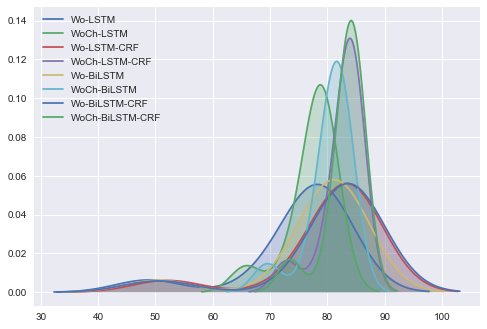

In [202]:
for nn in results_df_avg.index:
    sns.kdeplot(results_df_avg.transpose()[nn], shade=True)

# Statistical tests

## Nemeneyi 

In [203]:
results_df_avg

,fastText-wiki,Glove 42B,fastText-crawl,Amazon Reviews,Glove 6B 100,numberbatch,Glove 6B 50,Glove 840B,Glove 6B 200,Glove 6B 300,word2vec
Wo-LSTM,77.67,81.28,80.80,48.78,75.04,76.26,70.24,80.91,78.69,79.22,77.73
WoCh-LSTM,78.74,80.91,79.91,65.81,78.04,76.11,73.35,81.26,78.30,78.70,78.15
Wo-LSTM-CRF,84.43,85.64,85.46,52.09,82.52,82.19,76.16,85.02,83.26,82.70,82.49
WoCh-LSTM-CRF,84.96,85.37,85.25,72.84,82.79,82.92,79.38,84.91,83.30,82.56,84.12
Wo-BiLSTM,80.85,83.08,83.17,50.49,81.30,78.57,75.97,83.56,82.09,81.31,80.16
WoCh-BiLSTM,81.75,83.64,83.27,69.53,79.47,80.89,77.64,83.55,80.87,81.50,81.39
Wo-BiLSTM-CRF,84.62,84.97,85.28,50.63,84.01,82.31,79.03,84.96,83.81,82.99,82.94
WoCh-BiLSTM-CRF,84.54,86.05,85.69,73.50,84.16,82.85,80.79,85.20,83.74,83.26,83.61


In [204]:
def compare_no_control(df: pd.DataFrame, use_rank: bool):
    r_df = pandas2ri.py2ri(df)
    friedman_test = scmamp.multipleComparisonTest(r_df, test='iman')
    friedman_p_value = friedman_test.rx2('p.value')[0]
    ranks, _, posthoc_pvals = scmamp.postHocTest(
        data=r_df, test="friedman", correct="hommel", use_rank=use_rank)
    c_pval = pd.DataFrame(
        np.asarray(posthoc_pvals), columns=df.columns, index=df.columns)
    return friedman_p_value, list(ranks), c_pval

In [205]:
def plot_nemenyi_with_cd(df):
    _, avranks, _ = compare_no_control(df, True)
        
    cd = Orange.evaluation.compute_CD(avranks, df.shape[0])
    Orange.evaluation.graph_ranks(
        avranks,
        list(df.columns),
        cd=cd,
        width=10,
        textspace=1.5
    )
    plt.show()

TypeError: 'rpy2.rinterface.RNULLType' object is not iterable

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fbcf5673508 / R:0x5574b10e4348>
[RNULLType, RNULLType, RNULLType, RNULLType]
  <no name>: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  <no name>: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  <no name>: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  <no name>: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL

### Embeddings

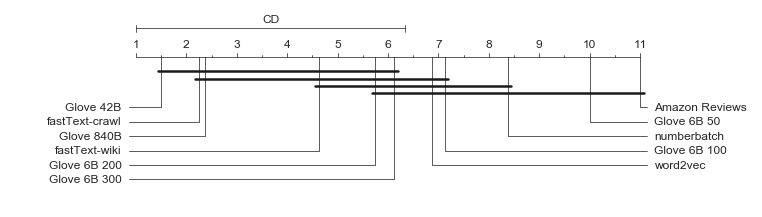

In [206]:
plot_nemenyi_with_cd(results_df_avg)

## Bergmann

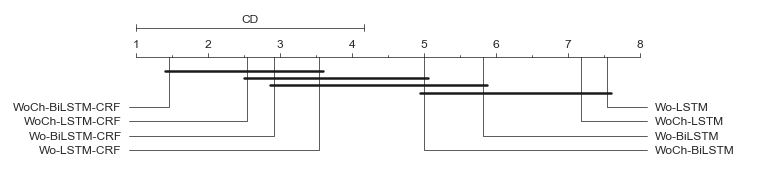

In [208]:
plot_nemenyi_with_cd(results_df_avg.transpose())

In [107]:
# scmamp.plotCD(r_df, alpha=0.05, cex=0.55)

# friedman_test = scmamp.multipleComparisonTest(r_df, control = 'NoEmbedding', test='iman')
# friedman_p_value = friedman_test.rx2('p.value')[0]
# ranks, _, posthoc_pvals = scmamp.postHocTest(data=r_df, test="friedman", control = 'NoEmbedding', correct="holland", use_rank = True)

# Check coverage of words in embeddings for aspect datasets

## Create corpus 

In [3]:
corpus_words = statistics_dataset.get_unique_words_from_corpus()

from more_itertools import flatten

corpus_words_all = set(flatten(corpus_words.values()))

len(corpus_words_all)

Corpus iterator: 49475it [00:00, 541770.29it/s]
Corpus iterator: 53781it [00:00, 974902.28it/s]
Corpus iterator: 12470it [00:00, 909854.24it/s]
Corpus iterator: 13257it [00:00, 584990.04it/s]


In [9]:
def load_word_embeddings(file_path):
    with open(file_path, encoding='utf-8') as fp:
        words = []
        try:
            for line in tqdm_notebook(fp, desc=file_path + ': embedding loading'):
                line_fields = line.split()
                if len(line_fields) < 5:
                    continue
                else:
                    if line[0] == ' ':
                        pass
                    else:
                        word = line_fields[0]
                        try:
                            pass
                        except:
                            continue
                        words.append(word)
        except UnicodeDecodeError:
            pass
    return set(words)

In [13]:
EMBEDDINGS_PATH = Path('/home/laugustyniak/data/embeddings/')

EMBEDDINGS = [
    'GoogleNews-vectors-negative300.txt',
    'glove.6B.50d.txt',
    'glove.6B.100d.txt',
    'glove.6B.200d.txt',
    'glove.6B.300d.txt',
    'glove.twitter.27B.200d.txt',
    'glove.42B.300d.txt',
    'glove.840B.300d.txt',
    'numberbatch-en.txt',
    'crawl-300d-2M.vec',
#     'wiki-news-300d-1M-subword.vec',
    'wiki-news-300d-1M.vec',
#     'bow2.words',
#     'bow2.contexts',
#     'bow5.words',
#     'bow5.contexts',
#     'deps.words',
#     'deps.contexts',
#     'sota-google.txt',
#     'sota-retrofit-600.txt',
#     'sota-sswe-50.txt',
#     'sota-wiki-600.txt',
    'sentic2vec.txt',
#     'lexvec.commoncrawl.ngramsubwords.300d.W.pos.vectors',
#     'lexvec.enwiki+newscrawl.300d.W.pos.vectors',    
]

In [7]:
def get_word_embeddings_vocabularies(word_embedding_names):
    return {
        word_embedding_name: load_word_embeddings((EMBEDDINGS_PATH / word_embedding_name).as_posix())
        for word_embedding_name 
        in tqdm_notebook(word_embedding_names)
    }
   
word_embedding_vocabulalaries = get_word_embeddings_vocabularies(EMBEDDINGS)

In [8]:
def get_datasets_coverage_with_word_embedding(corpus_words, word_embedding_vocabulalaries):
    word_embedding_coverage = {}
    for word_embedding_name, vocabulary in word_embedding_vocabulalaries.items():
        word_embedding_coverage[word_embedding_name] = {
            corpus_name: len(words.difference(vocabulary))/len(words)
            for corpus_name, words
            in corpus_words.items()
        }
    return word_embedding_coverage

In [9]:
{k: len(v) for k, v in  corpus_words.items()}

{'Restaurants_poria-train': 4619,
 'Laptops_poria-train': 4238,
 'Laptops_poria-test': 1922,
 'Restaurants_poria-test': 2270}

In [10]:
{word_embedding_name: len(vocabulary) for word_embedding_name, vocabulary in word_embedding_vocabulalaries.items()}

{'GoogleNews-vectors-negative300.txt': 2999993,
 'glove.6B.50d.txt': 400000,
 'glove.6B.100d.txt': 400000,
 'glove.6B.200d.txt': 400000,
 'glove.6B.300d.txt': 400000,
 'glove.twitter.27B.200d.txt': 1193515,
 'glove.42B.300d.txt': 1917494,
 'glove.840B.300d.txt': 2195884,
 'numberbatch-en.txt': 417194,
 'crawl-300d-2M.vec': 1999995,
 'wiki-news-300d-1M.vec': 999994,
 'sentic2vec.txt': 42007}

In [11]:
datasets_coverage_with_word_embedding = get_datasets_coverage_with_word_embedding(corpus_words, word_embedding_vocabulalaries)

In [12]:
lack_of_words_percentage = pd.DataFrame(datasets_coverage_with_word_embedding).round(4)*100

In [89]:
lack_of_words_percentage.to_excel((results_path / 'word-embeddings-coverage.xlsx').as_posix())
lack_of_words_percentage

,GoogleNews-vectors-negative300.txt,glove.6B.50d.txt,glove.6B.100d.txt,glove.6B.200d.txt,glove.6B.300d.txt,glove.twitter.27B.200d.txt,glove.42B.300d.txt,glove.840B.300d.txt,numberbatch-en.txt,crawl-300d-2M.vec,wiki-news-300d-1M.vec,sentic2vec.txt
Laptops_poria-test,8.38,4.27,4.27,4.27,4.27,8.17,1.77,2.24,9.83,2.39,4.68,17.17
Laptops_poria-train,11.14,9.18,9.18,9.18,9.18,11.70,3.40,4.20,14.06,4.32,6.91,18.55
Restaurants_poria-test,9.25,7.40,7.40,7.40,7.40,8.63,3.66,4.36,9.12,4.27,6.70,32.20
Restaurants_poria-train,12.73,10.78,10.78,10.78,10.78,11.99,5.00,6.11,13.70,5.98,9.33,34.38


In [ ]:
print(pd.DataFrame.from_dict(aspects, orient='index', columns=['Multi aspect ']).to_latex())

# Trim words in word embeddings but not in datasets 

In [19]:
def save_intersection_between_word_embedding_and_corpus(word_embedding_path: Path, corpus_words: Set[str], word_embedding_name_suffix: str = 'trimmed'):
    word_embedding_trimmed_path = word_embedding_path.parent / f'{word_embedding_path.name}-{word_embedding_name_suffix}.txt' 
    trimmed_file = open(word_embedding_trimmed_path, 'w')
    intersected_words = 0
    
    with open(word_embedding_path, encoding='utf-8') as fp:
        for line in tqdm_notebook(fp, desc=word_embedding_path.name + ': embedding trimming'):
            try:
                line_fields = line.split()
                if len(line_fields) < 5:
                    continue
                else:
                    word = line_fields[0]
                    if word in corpus_words:
                        trimmed_file.writelines([line])
                        intersected_words += 1
            except UnicodeDecodeError:
                pass
        trimmed_file.close()
    print(f'Intersected words {intersected_words} in {word_embedding_path}')

In [20]:
for embedding_path in tqdm_notebook(EMBEDDINGS):
    save_intersection_between_word_embedding_and_corpus(
        EMBEDDINGS_PATH / embedding_path,
        corpus_words_all
    )

Intersected words 6991 in /home/laugustyniak/data/embeddings/GoogleNews-vectors-negative300.txt


Intersected words 7220 in /home/laugustyniak/data/embeddings/glove.6B.50d.txt


Intersected words 7220 in /home/laugustyniak/data/embeddings/glove.6B.100d.txt


Intersected words 7220 in /home/laugustyniak/data/embeddings/glove.6B.200d.txt


Intersected words 7220 in /home/laugustyniak/data/embeddings/glove.6B.300d.txt


Intersected words 7064 in /home/laugustyniak/data/embeddings/glove.twitter.27B.200d.txt


Intersected words 7806 in /home/laugustyniak/data/embeddings/glove.42B.300d.txt


Intersected words 7725 in /home/laugustyniak/data/embeddings/glove.840B.300d.txt


Intersected words 6817 in /home/laugustyniak/data/embeddings/numberbatch-en.txt


Intersected words 7699 in /home/laugustyniak/data/embeddings/crawl-300d-2M.vec


Intersected words 7385 in /home/laugustyniak/data/embeddings/wiki-news-300d-1M.vec


Intersected words 5604 in /home/laugustyniak/data/embeddings/sentic2vec.txt



# Words/aspects appeared in test data but not in training 

In [ ]:
from collections import namedtuple

## Words statistics 

In [ ]:
WordsStats = namedtuple('WordsStats', 'coverage, all_unique_words')

In [ ]:
def words_coverage_stats(train_words: Set, test_words: Set):
    all_words = train_words.union(test_words)
    intersection_words = train_words - test_words
    return WordsStats(
        len(intersection_words)/len(all_words),
        len(all_words)
    )

In [ ]:
words_coverage_stats(corpus_words[statistics_dataset.dataset_restaurants_train], corpus_words[statistics_dataset.dataset_restaurants_test])

In [ ]:
words_coverage_stats(corpus_words[statistics_dataset.dataset_laptops_train], corpus_words[statistics_dataset.dataset_laptops_test])